# Multi-Armed Bandit

This is a classic problem in optimisation. The setup is that an agent is faced with multiple bandits (bandits are those kind of gambling machines in which one pulls on a lever and possibly gets reward). Each bandit has a fixed possibility of sucsess (in the simplest version of the problem). The question is simply which is the optimal bandit to choose. This is of course trivial, the agent should choose the bandit with the highest probability of sucsess, except that we do not know the probablity. This is hidden from us.

Label the bandits with probabilities P(a), where a labels the bandit in question. With probability P(a) bandit a gives a reward of one, otherwise it gives a reward of zero.

The agent has a belief about the probability of bandit a, labeled by Q(A).

We could simply pull the arm multiple times and take the mean of rewards to estimate the reward for a given bandit, thus:

$$Q_K(a) = \frac{1}{k}(r_1 + r_2 + ... + r_k)$$

The agents belief about p(a), after k trials of that bandit, is the mean of the rewards of previous trials, r_i labels the reward at trial i.

A agent that was most interested in information, rather than reward, might try the bandits at random (there may be a more optimal strategy for maximising information). 

An agent the is most intereseted in imediate reward would always try the bandit with the highest q.

The information maximizing agent would in fact gather lots of information, but never be able to use it. The greedy agent would never find out, and would likely get stuck with a sub-optimal bandit.

An epsilon greedy agent does the optimal thing, but with probability epsilon, does something at random, this way it can continue to gather information.

This is a very simple agent, there is probably something much more optimal, but let's code this.

In [36]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,9)

In [22]:
class MultiArmedBandit:
    """
    Simplest version of the multi-armed bandit. It has n bandits. The probabilities of which
    are chossen at random from a uniform distribution.
    """
    
    def __init__(self, n):
        self.n = n
        self._ps = self._set_ps()
        
    def _set_ps(self):
        return np.random.random(size=self.n)
    
    def get_reward(self, n):
        """
        Return a reward, either one or zero, for playing bandit n.
        """
        
        return 1 if np.random.random() < self._ps[n] else 0

In [23]:
class Agent:
    
    def __init__(self, epsilon, n):
        self.n = n
        self.epsilon = epsilon
        self.qs = np.array([1/2]*self.n)
        self.reward = 0
        # Number of times each bandit has been played.
        self.plays = np.zeros(self.n)

    def _max(self):
        """
        Return the bandit with the highest probability of sucsess.
        If there is a draw then it defaults to the lowest number.
        """
        
        return np.argmax(self.qs)
    
    def choose_bandit(self):
        """
        Choose a bandit to play.
        """
        
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n)
        else:
            return self._max()

    def update(self, a, r):
        """
        Update after playing n, recieving reward r
        """
        
        self.reward += r
        k = self.plays[a]
        self.qs[a] = (self.qs[a]*k + r)/(1 + k)
        self.plays[a] += 1


Now we can set the whole thing going in a loop.

In [34]:
n = 12
N = 10000
epsilon = 0.1

ma = MultiArmedBandit(n)
agent = Agent(epsilon, n)

running_plays = [np.zeros(n)]

rs = []
for _ in range(N):
    a = agent.choose_bandit()
    r = ma.get_reward(a)
    rs.append(r)
    agent.update(a, r)
    running_plays.append(list(agent.plays))

max_possible = max(ma._ps)

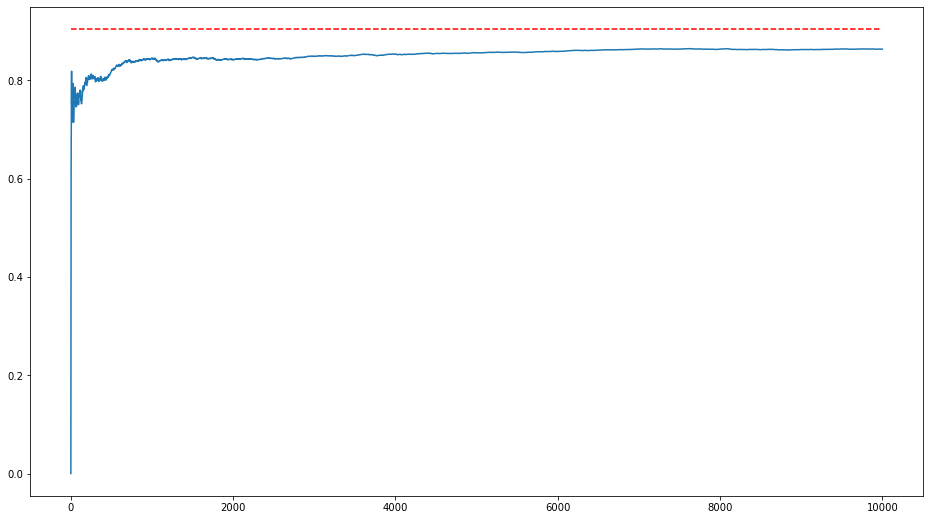

In [43]:
ax = plt.plot([np.mean(rs[:i]) for i in range(1, len(rs))])
plt.plot([0, N], [max_possible]*2, '--', color='red')

### Other Strategies

This simple strategy is a bit wasteful, at the beginning it might choose something that it thinks is optimal, based on one or very few observations. Later it wastes time continually trying new things even though the answer has become quite certain.

The simplest solution to this would be to have epsilon decrease with time. Start high, and then decrease.

Another option is an upper bound algorithm. Rather than taking the best guess for a given option as our belief, we use an upper bound. We take the highest probability that a bandit could be, within some bound, e.g. we might say that there is at least a 5% chance that option 3 has p of 0.9. The more times we have played a certain option the lower the upper bound is, thus this strategy encourages us to play those options that we have done few times before.

The upper threshold can be set with something called Hoefding's inequality. You must choose how uncertain (or alternatively how optimistic) you want to be.

#### Upper Bound Strategie

The strategy is to put an upper bound on the probability of p < x, and find the x such that this probability is small. In other words we are reasonably certain that p cannot be less than some upper bound, and typically set this probability as quite small.

We can use general upper bound theorems for unknown class of distibutions, but here we are assuming that the distrubution is uniform and in [0,1]. To solve this we can use the Hoefding's inequality. It puts a bound on how far a sample mean can be from an actual mean.

The formular is:


$$\epsilon = \sqrt{\frac{-log(p)}{2n}}$$

It says that the difference between our sample mean, and the real mean, $\epsilon$ is at most that much, where p is the probability that we choose, and n is the number of trials that we have conducted. So we add this amount to our q(a), i.e. we overestimate the probablity of sucsess for each arm of the bandit. Note that this overestimationg becomes increasingly small as we do more and more trials.

Let's try out this formular in isolation first.

In [73]:
def upper_bound(q, eps, N):
    """
    Return the upper bound on the probability for a given trial, given that you have an observed mean
    of q, and have conducted N. eps is specified by the user, and tells you how optimistic to be. I.e. with
    probabilty of at least e the upper bound is this.
    """
    
    result = q + np.sqrt(-np.log(eps)/(2*N))
    if result > 1:
        return 1
    else:
        return result

In [82]:
p = 0.3
def trial(p):
    return 1 if np.random.random() < p else 0

In [85]:
# our initial guess for the probability is a half.
q = 0.5
qs = [q]
total_trials = 10001
eps = 0.05
ub = upper_bound(q, eps, 0)
ubs = [ub]
for k in range(total_trials):
    r = trial(p)
    q = (q*k + r)/(1 + k)
    qs.append(q)
    ub = upper_bound(q, eps, k)
    ubs.append(ub)

<ipython-input-73-9fb60b784347>:8: RuntimeWarning: divide by zero encountered in double_scalars
  result = q + np.sqrt(-np.log(eps)/(2*N))


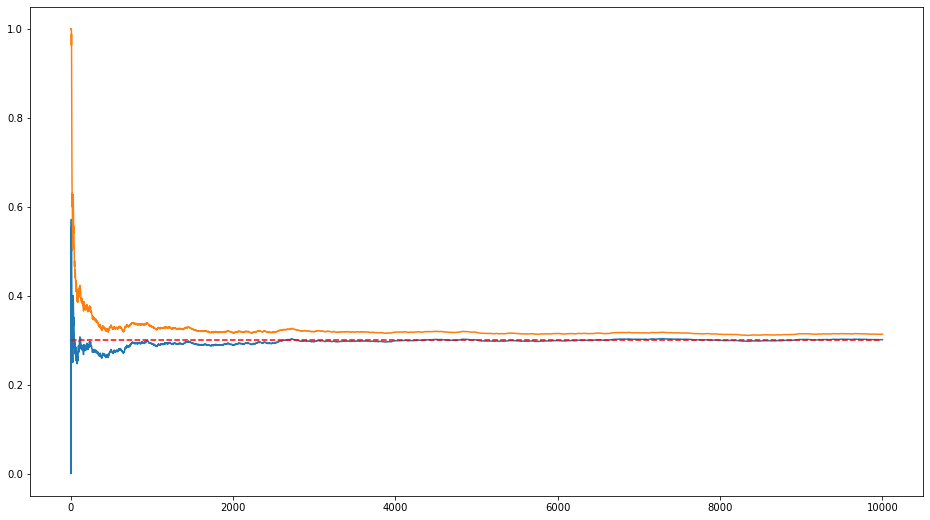

In [86]:
plt.plot(qs)
plt.plot(ubs)
plt.plot([0, total_trials], [p]*2, '--', color='red')


Let's test this out as a bandit. The implementation is mostly the same, we only need to change the calculation of the qs to add the upper bound. Let's try it out.

In [88]:
class OptimisticAgent:
    
    def __init__(self, epsilon, n):
        self.n = n
        self.epsilon = epsilon
        self.qs = np.array([1/2]*self.n)
        self.uppers = np.array([1.]*self.n)
        self.reward = 0
        # Number of times each bandit has been played.
        self.plays = np.zeros(self.n)
    
    def choose_bandit(self):
        """
        Choose a bandit to play.
        """

        return np.argmax(self.uppers)

    def update(self, a, r):
        """
        Update after playing n, recieving reward r
        """
        
        self.reward += r
        k = self.plays[a]
        self.qs[a] = (self.qs[a]*k + r)/(1 + k)
        self.plays[a] += 1
        self.uppers[a] = upper_bound(self.qs[a], self.epsilon, self.plays[a])


In [116]:
n = 12
N = 500000
epsilon = 0.01

ma = MultiArmedBandit(n)
max_possible = max(ma._ps)
agent = OptimisticAgent(epsilon, n)

running_plays = [np.zeros(n)]

running_means = [0] 
for k in range(N):
    a = agent.choose_bandit()
    r = ma.get_reward(a)
    rs.append(r)
    agent.update(a, r)
    new_mean = (running_means[-1]*k + r)/(1 + k)
    running_means.append(new_mean)
    
# and run the other one for comparison
epsilon = 0.1
agent = Agent(epsilon, n)

running_plays = [np.zeros(n)]

running_means2 = [0] 
for k in range(N):
    a = agent.choose_bandit()
    r = ma.get_reward(a)
    rs.append(r)
    agent.update(a, r)
    new_mean = (running_means[-1]*k + r)/(1 + k)
    running_means2.append(new_mean)


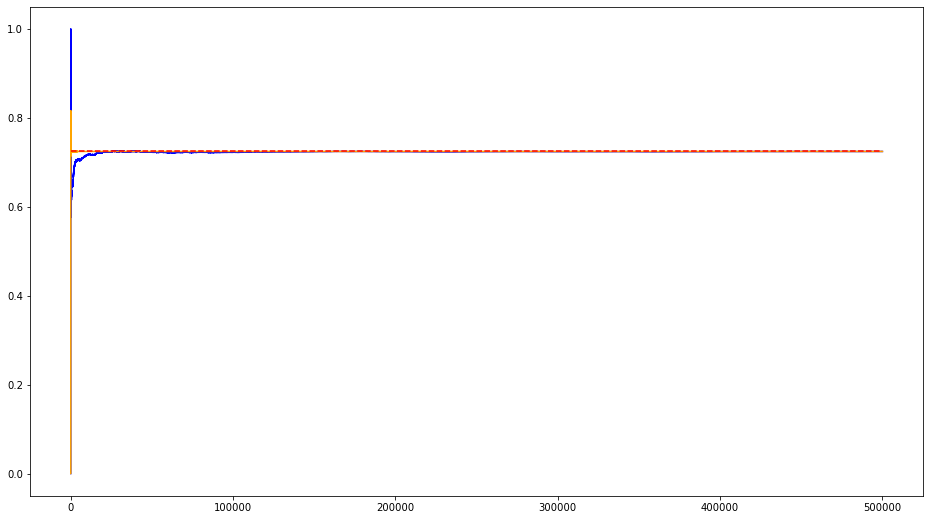

In [117]:
plt.plot(running_means, color='blue')
plt.plot(running_means2, color='orange')
plt.plot([0, N], [max_possible]*2, '--', color='red')

It's not that